# Vehicle Detection


## The goals / steps of this project are the following
***

1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
 Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
2. Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
3. Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
4. Estimate a bounding box for vehicles detected.


## 0. Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import os
import glob
import copy
import random

## 1. HOG feature extraction

### 1.1 Read input images

The number of vehicles images : 8792
The number of non-vehicles images : 8968
Visualizing Images


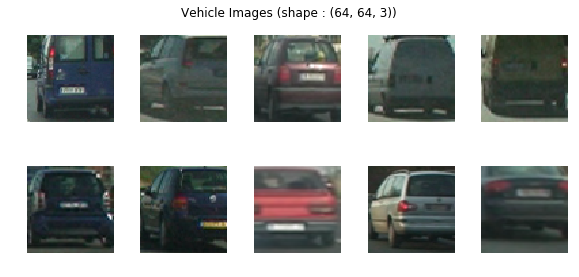

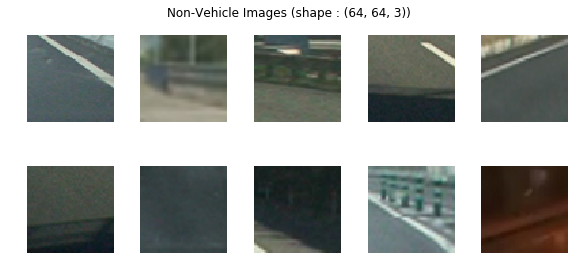

In [2]:
#####
# Reading & Visualize vehicle/non-vehicle images
vehicle_path = "../dataset/vehicles/*/"
non_vehicle_path = "../dataset/non-vehicles/*/"
vehicle_images = glob.glob(vehicle_path+'*.png')
non_vehicle_images = glob.glob(non_vehicle_path+'*.png')

num_vehicles=len(vehicle_images)
num_non_vehicles=len(non_vehicle_images)

print("The number of vehicles images : %d" % num_vehicles)
print("The number of non-vehicles images : %d" % num_non_vehicles)

# Read in RGB format with range (0,256)
cars = []
for f in vehicle_images:
    cars.append(cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB))
notcars = []
for f in non_vehicle_images:
    notcars.append(cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB))
    
train_img = np.vstack([cars, notcars])

#print (len(train_img))

#####
# Creating Labels
labels_vehicle = np.ones(num_vehicles)
labels_non_vehicle = np.zeros(num_non_vehicles)
train_label = np.hstack([labels_vehicle, labels_non_vehicle])

train_img_shape = train_img[0].shape

#####
# Visualizing train images
print("Visualizing Images")
rows=2
cols=5
fig, ax = plt.subplots(rows, cols, figsize=(10, 4))
fig.subplots_adjust(hspace = .5, wspace=.1)
for i in range(rows):
    for k in range(cols):
        ax[i][k].set_axis_off()
        ax[i][k].imshow(train_img[i*cols+k])
plt.suptitle("Vehicle Images (shape : {})".format(train_img_shape))
plt.show()

rows=2
cols=5
fig, ax = plt.subplots(rows, cols, figsize=(10, 4))
fig.subplots_adjust(hspace = .5, wspace=.1)
for i in range(rows):
    for k in range(cols):
        ax[i][k].set_axis_off()
        ax[i][k].imshow(train_img[num_vehicles+i*cols+k])
plt.suptitle("Non-Vehicle Images (shape : {})".format(train_img_shape))
plt.show()


### 1.2. HOG features

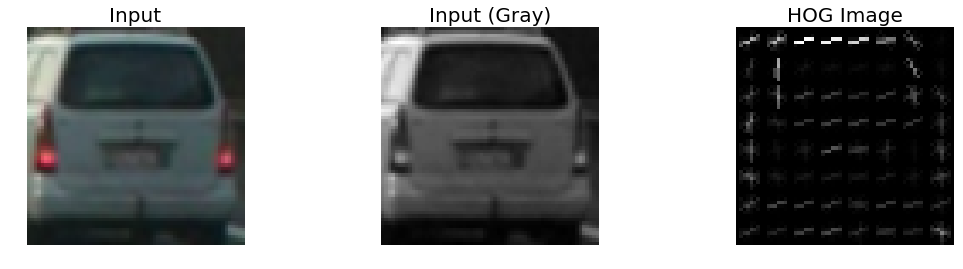

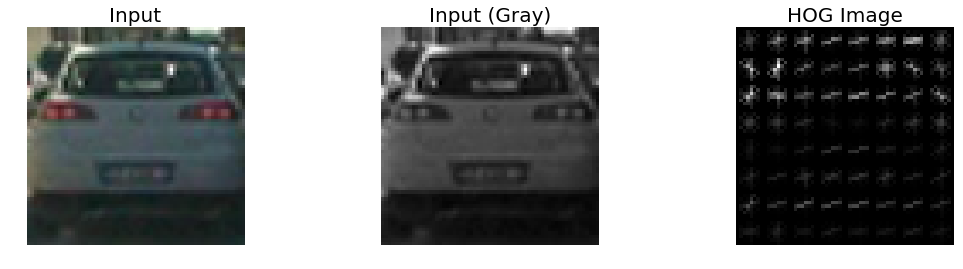

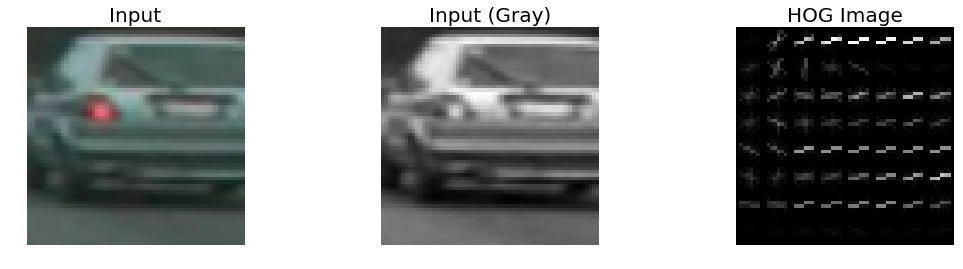

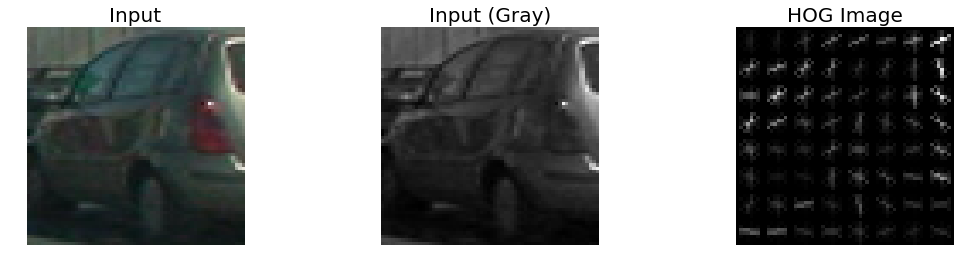

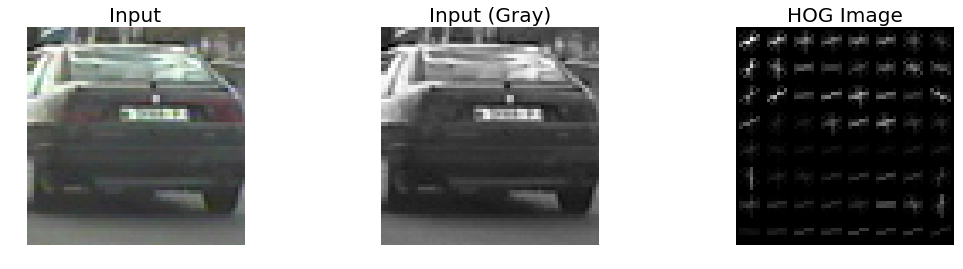

In [23]:

from skimage.feature import hog

#####
# hog feature extraction 

# if vis==True, two output (features, hog_image)
# else,         one ouput (features)
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    

    if vis == True:
        # do hog only for gray scale to visualize
        hog_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        features, hog_image = hog(hog_img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        # do hog for every channel to extract real features
        features=[]
        hog_img = img[:,:,0]
        hog_features = hog(hog_img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        features=hog_features
        hog_img = img[:,:,1]
        hog_features = hog(hog_img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        features=features+hog_features
        hog_img = img[:,:,2]
        hog_features = hog(hog_img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        features=features+hog_features
        '''
        hog_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        features = hog(hog_img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        '''
        
    return features


orient = 11
pix_per_cell = 8
cell_per_block = 2
for i in range(0,5):
    img_index = random.randint(1,1000)
    test_img=train_img[img_index]
    hog_features, hog_image = get_hog_features(test_img, orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))
    ax[0].set_axis_off()
    ax[0].set_title("Input", fontsize=20)
    ax[0].imshow(test_img)
    ax[1].set_axis_off()
    ax[1].set_title("Input (Gray)", fontsize=20)
    ax[1].imshow(cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY), cmap='gray')
    ax[2].set_axis_off()
    ax[2].set_title("HOG Image", fontsize=20)
    ax[2].imshow(hog_image, cmap='gray')
    plt.show()

    
    
    

### 1.3. Spatial features (bin)

In [4]:
#####
# Spatial feature extraction
# Not visualize this, because it is pretty obvious

def bin_spatial(img, size=(32, 32)):
    return cv2.resize(img, size).ravel() 



### 1.4. Color Histogram

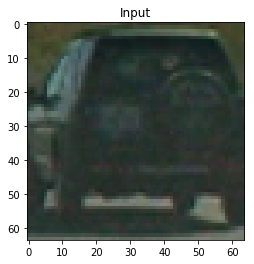

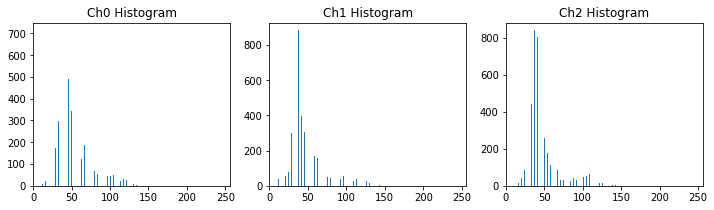

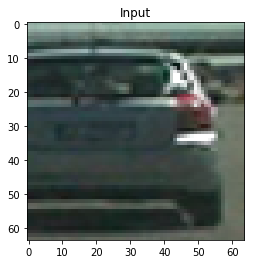

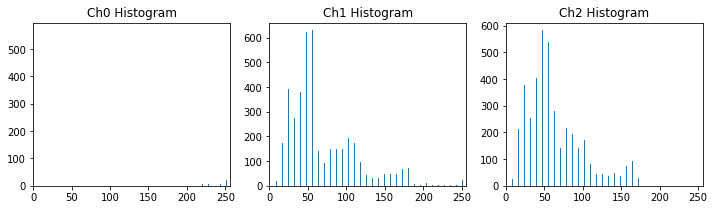

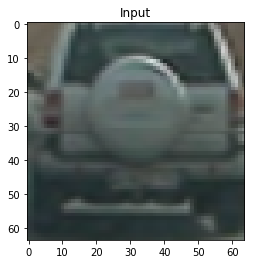

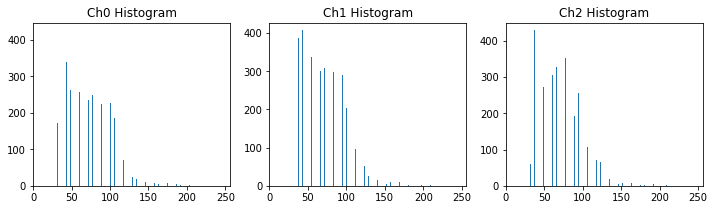

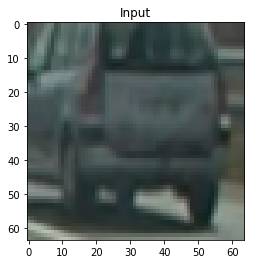

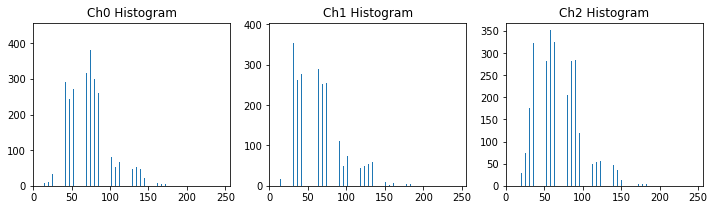

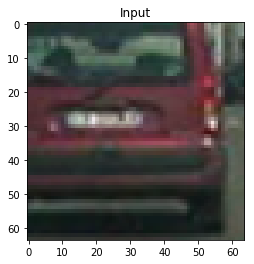

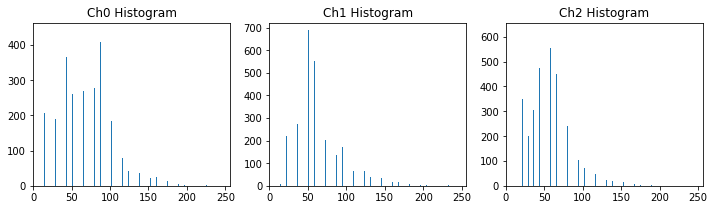

In [5]:
#####
# Color histogram features
def color_hist(img, nbins=32, display=False):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

    if display==True:
        # Generating bin centers
        bin_edges = channel1_hist[1]
        bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

        plt.title('Input')
        plt.imshow(img)
        # Plot a figure with all three bar charts
        fig = plt.figure(figsize=(12,3))
        plt.subplot(131)
        plt.bar(bin_centers, channel1_hist[0])
        plt.xlim(0, 256)
        plt.title('Ch0 Histogram')
        plt.subplot(132)
        plt.bar(bin_centers, channel2_hist[0])
        plt.xlim(0, 256)
        plt.title('Ch1 Histogram')
        plt.subplot(133)
        plt.bar(bin_centers, channel3_hist[0])
        plt.xlim(0, 256)
        plt.title('Ch2 Histogram')
        plt.show()
    return hist_features

for i in range(0,5):
    img_index = random.randint(1,1000)
    test_img=train_img[img_index]
    hist_features = color_hist(test_img, display=True)


### 1.5. Combine and extract features 

In [32]:
#####
# Combine features (hog, spatial_bin, histogram) , with color space conversion

def extract_features(rgb_img, hog=True, spatial_bin=True, histogram=True, \
                    color_space='RGB', \
                    orient = 9, pix_per_cell = 8, cell_per_block = 2, \
                    spatial_size=(32,32), \
                    nbins=32):
    
    
    # Color space conversion for histogram and spatial bin
    if color_space != 'RGB':
        if color_space == 'HSV':
            f_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            f_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            f_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            f_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            f_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2YCrCb)
    else: f_img = np.copy(rgb_img)      

        
    # HOG Features , always done in RGB space
    if hog==True:
        hog_features =  get_hog_features(rgb_img, orient, pix_per_cell, cell_per_block, 
                                         vis=False, feature_vec=True)
        
        
    if spatial_bin==True:
        spatial_features = bin_spatial(f_img, size=spatial_size)

    if histogram == True:
         # Apply color_hist()
        hist_features = color_hist(f_img, nbins=nbins)
    
#     print(hog_features)
#     print(spatial_features)
#     print(hist_features)
    features = np.hstack([hog_features, spatial_features, hist_features])
    return features


#####
# Parameters for feature extraction
use_hog=True
use_spatial_bin=True
use_histogram=True
color_space='LUV'
orient = 11
pix_per_cell = 8
cell_per_block = 2
spatial_size=(16,16)
histogram_nbins=32

#####
# Extract Features
train_features = []
for img in train_img:
    train_features.append(extract_features(img, use_hog, use_spatial_bin, use_histogram,\
                                          color_space, \
                                          orient, pix_per_cell, cell_per_block, \
                                          spatial_size, \
                                          histogram_nbins))

train_features = np.asarray(train_features, np.float64)


### 1.6. Linear SVM

In [33]:
#####
# Spliting data into training and test sets, and randomize
random_state=random.randint(1, 100) 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_features, train_label, test_size=0.2, random_state=random_state)

print("Train set size : %d"%len(X_train))
print("Test set size : %d"%len(X_test))


#####
# Scaler set-up to normalize train dataset
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

#####
# Use a linear SVC 
from sklearn.svm import LinearSVC
svc = LinearSVC()
# Check the training time for the SVC
svc.fit(X_train, y_train)
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))




Train set size : 14208
Test set size : 3552
Test Accuracy of SVC =  0.9806


## 2. Sliding window

### 2.1. Sliding window

['./test_images/test6.jpg', './test_images/test4.jpg', './test_images/test5.jpg', './test_images/test1.jpg', './test_images/test3.jpg', './test_images/test2.jpg']
(720, 1280, 3)


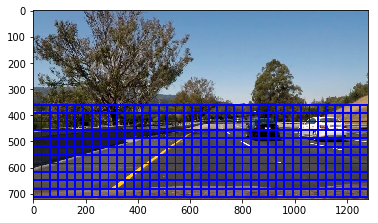

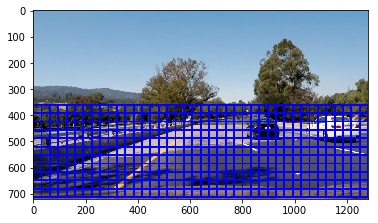

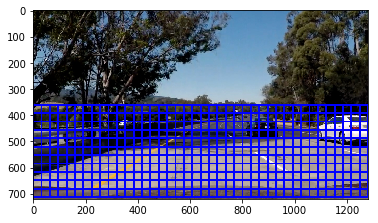

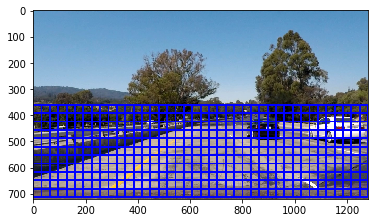

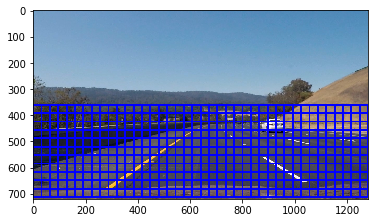

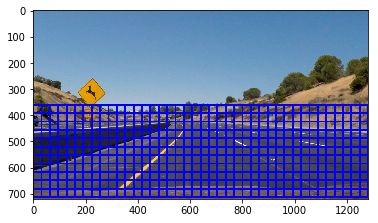

In [34]:

##### Read test files
test_files = glob.glob("./test_images/*.jpg")
print(test_files)
test_images = []
for f in test_files:
    img = cv2.imread(f)
    test_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

test_shape=test_images[0].shape
print(test_shape)

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[int(test_shape[0]/2), None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


for img in test_images:
    windows = slide_window(img)
    window_img = draw_boxes(img, windows, color=(0, 0, 255), thick=6)                    
    plt.imshow(window_img)
    plt.show()

In [35]:

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
#         features = single_img_features(test_img, color_space=color_space, 
#                             spatial_size=spatial_size, hist_bins=hist_bins, 
#                             orient=orient, pix_per_cell=pix_per_cell, 
#                             cell_per_block=cell_per_block, 
#                             hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                             hist_feat=hist_feat, hog_feat=hog_feat)
       
        features = extract_features(test_img, use_hog, use_spatial_bin, use_histogram,\
                                          color_space, \
                                          orient, pix_per_cell, cell_per_block, \
                                          spatial_size, \
                                          histogram_nbins)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
print(train_features.shape)
windows = slide_window(img)
windows2 = slide_window(img, xy_window=(96,96))
windows3 = slide_window(img, xy_window=(48,48))
#windows3 = slide_window(img, xy_window=(32,32))
windows=windows+windows2+windows3
# for img in test_images:
#     #print(np.shape(windows))
#     #windows = np.vstack([windows, windows2])
    
#     detect_windows = search_windows(img, windows, svc, X_scaler)
#     draw_image=np.copy(img)
#     window_img = draw_boxes(draw_image, detect_windows, color=(0, 0, 255), thick=6)                    
#     plt.imshow(window_img)
#     plt.show()

(17760, 3020)


In [36]:

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

    
    


./output_images/test6.jpg


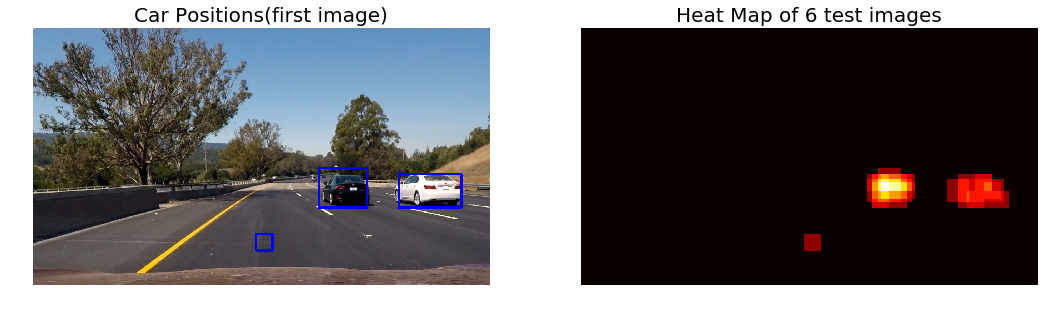

./output_images/test4.jpg


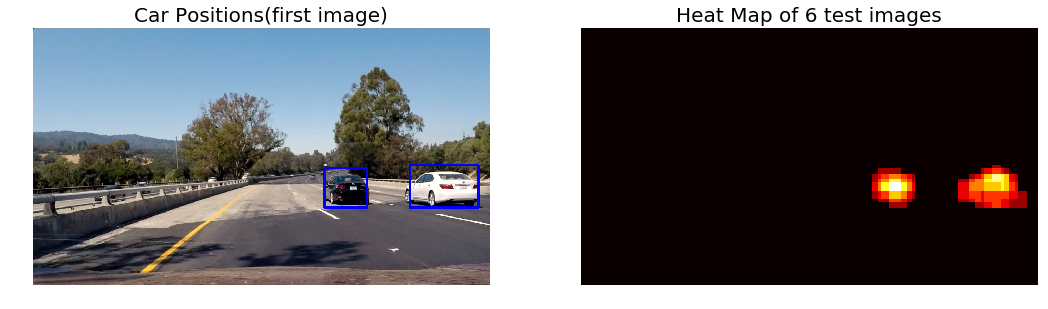

KeyboardInterrupt: 

In [54]:
from scipy.ndimage.measurements import label
#labels = label(heatmap)


box_list=np.empty([0,2,2])

for i in range(len(test_images)):
    img = test_images[i]
    
    #windows = slide_window(img)
    #windows2 = slide_window(img, xy_window=(128,128))
    #windows3 = slide_window(img, xy_window=(32,32))
    #windows=windows+windows3
    #print(np.shape(windows))
    #windows = np.vstack([windows, windows2])
    
    global windows
    
    detect_windows = search_windows(img, windows, svc, X_scaler)
#    if len(detect_windows)!=0:
#        box_list=np.vstack((box_list, detect_windows))
    
   # Add heat to each box in box list
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,detect_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)


    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    ax[0].set_axis_off()
    ax[0].set_title("Car Positions(first image)", fontsize=20)
    ax[0].imshow(draw_img)
    ax[1].set_axis_off()
    ax[1].set_title("Heat Map of 6 test images", fontsize=20)
    ax[1].imshow(heatmap, cmap='hot')
    
    #fig.savefig('./output_images/'+test_files[i].split('/')[-1])
    print ('./output_images/'+test_files[i].split('/')[-1])
    plt.show()


## Test on Videos


In [40]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [47]:

saved_box_list=[]
frame_count=0
stack_threshold=5
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    global windows
    detect_windows = search_windows(image, windows, svc, X_scaler)
    
    global frame_count
    frame_count += 1
    if frame_count>stack_threshold:
        saved_box_list.pop(0)
    
    
    if(len(detect_windows)==0):
        detect_windows=np.zeros([1,2,2])
        
    saved_box_list.append(detect_windows)
    #print(len(saved_box_list))

    box_list=np.empty([0,2,2])
    for box in saved_box_list:
        box_list = np.vstack((box_list, box))
    
    # print(len(box_list))
    # Add heat to each box in box list
    heat = np.zeros_like(test_images[0][:,:,0]).astype(np.float)
    heat = add_heat(heat,box_list.astype(np.int))

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,10)

    #print(heat)
    # Visualize the heatmap when displaying    
    # heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heat)
    result = draw_labeled_bboxes(image, labels)
    
    
    return result

Let's try the one with the solid white lane on the right first ...

In [50]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

out_dir='./output_images/'
white_output = out_dir + 'output_video.mp4'
clip1 = VideoFileClip("./project_video.mp4")
#clip1 = VideoFileClip("./project_video.mp4").subclip(7,10)

white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./output_images/output_video.mp4
[MoviePy] Writing video ./output_images/output_video.mp4



 12%|█▏        | 147/1261 [17:59<2:16:08,  7.33s/it]


 23%|██▎       | 293/1261 [35:52<1:58:35,  7.35s/it]


 35%|███▍      | 439/1261 [53:38<1:39:29,  7.26s/it]


 46%|████▌     | 582/1261 [1:10:56<1:22:09,  7.26s/it]


 57%|█████▋    | 723/1261 [1:28:05<1:05:22,  7.29s/it]


 69%|██████▉   | 867/1261 [1:45:32<47:46,  7.28s/it]


 80%|████████  | 1013/1261 [2:03:16<30:03,  7.27s/it]


 92%|█████████▏| 1156/1261 [2:20:33<12:41,  7.25s/it]


100%|█████████▉| 1260/1261 [2:33:13<00:07,  7.39s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/output_video.mp4 

CPU times: user 2h 33min 9s, sys: 3.75 s, total: 2h 33min 13s
Wall time: 2h 33min 13s


In [51]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))